
# Stock Trading Ensemble Model: End-to-End Pipeline

**Project:** AAI-464 Pattern Recognition & Classification  
**Model:** Weighted Ensemble (LightGBM + CatBoost)

This notebook documents the complete workflow for our stock prediction system. We are predicting **5-day forward returns** for a basket of banking stocks. The approach uses a heavy feature engineering pipeline (77+ features) combined with a robust feature selection process to feed a weighted ensemble model.


In [11]:

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our custom model classes
from models.ensemble_model import EnsembleModel
from config import Config

# Set plotting aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline



### 1. Data Acquisition

We retrieve historical daily bars from the Alpaca API. To capture market sentiment, we also fetch news headlines and process them using our custom dictionary-based sentiment analyzer.

*   **Training Universe:** 14 Major Banking Stocks (JPM, BAC, GS, etc.)
*   **Test Asset:** Citigroup (C) - strictly held out for validation.


In [12]:

# Initialize the Ensemble
# Weights: 40% LightGBM (Trend) + 60% CatBoost (Stability)
model = EnsembleModel(lgb_weight=0.4, cat_weight=0.6)

# Define stock universe
TRAIN_SYMBOLS = ['BAC', 'JPM', 'WFC', 'GS', 'MS', 'USB', 'PNC', 'AXP', 'COF', 'SCHW', 'BLK', 'BK', 'STT', 'TFC']
TEST_SYMBOLS = ['C']

print(f"Fetching data for {len(TRAIN_SYMBOLS)} training stocks and {len(TEST_SYMBOLS)} test stock...")
train_df, test_df = model.fetch_data(TRAIN_SYMBOLS, TEST_SYMBOLS)

print(f"Training Samples: {len(train_df)}")
print(f"Testing Samples:  {len(test_df)}")
train_df.head()


Fetching data for 14 training stocks and 1 test stock...
FETCHING DATA FROM ALPACA

FETCHING MULTI-STOCK DATA
Symbols: BAC, JPM, WFC, GS, MS, USB, PNC, AXP, COF, SCHW, BLK, BK, STT, TFC, C
Days per stock: default

Date range: 2024-12-05 to 2025-12-05 for BAC
Successfully fetched 250 trading days of data
Data columns: ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap']
    Fetching news for BAC...
    ✓ Added news data: 209 days with news
  ✓ BAC: 250 trading days
Date range: 2024-12-05 to 2025-12-05 for JPM
Successfully fetched 250 trading days of data
Data columns: ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap']
    Fetching news for JPM...
    ✓ Added news data: 266 days with news
  ✓ JPM: 250 trading days
Date range: 2024-12-05 to 2025-12-05 for WFC
Successfully fetched 250 trading days of data
Data columns: ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap']
    Fetchi

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,news_sentiment,news_volume
0,BAC,2024-12-06 00:00:00+00:00,47.06,47.06,46.400,46.75,28931688.0,125548.0,46.662234,0.000000,0.0
1,USB,2024-12-06 00:00:00+00:00,52.24,52.59,51.780,52.18,4683487.0,41576.0,52.100029,0.000000,0.0
2,SCHW,2024-12-06 00:00:00+00:00,81.69,82.17,81.410,81.47,5071471.0,58345.0,81.679807,0.000000,0.0
3,STT,2024-12-06 00:00:00+00:00,98.89,98.95,97.355,98.41,1726253.0,30112.0,98.245683,0.000000,0.0
4,GS,2024-12-06 00:00:00+00:00,597.16,600.00,594.370,599.68,1405677.0,46106.0,597.994837,0.133333,3.0



### 2. Feature Engineering

We generate a comprehensive set of **77 features** to model market dynamics. These include:
*   **Momentum:** RSI, MACD, Stochastic, Williams %R
*   **Volatility:** Bollinger Bands, ATR, Parkinson Volatility (High-Low range based)
*   **Market Context:** Relative strength vs SPY and XLF (Financial Sector)
*   **Sentiment:** Daily news sentiment scores and volume impact


In [13]:

print("Generating technical and sentiment features...")
FORWARD_DAYS = 5

# The prepare_data pipeline handles all feature generation and NaN cleaning
train_features = model.prepare_data(train_df, FORWARD_DAYS).dropna()
test_features = model.prepare_data(test_df, FORWARD_DAYS).dropna()

print(f"Feature Matrix Shape: {train_features.shape}")
# Preview a mix of technical and sentiment features
train_features[['close', 'rsi_14', 'news_sentiment', 'parkinson_volatility']].tail()


Generating technical and sentiment features...
Feature Matrix Shape: (2814, 88)


,close,rsi_14,news_sentiment,parkinson_volatility
3490,106.43,43.696829,0.0,0.188421
3491,108.07,50.241213,0.0,0.195164
3492,109.13,51.478495,0.0,0.196625
3493,111.39,58.802608,0.0,0.200321
3494,112.10,57.518337,0.0,0.196675



### 3. Feature Selection

Using all 77 features can lead to overfitting. We implement a selection strategy to pick the **Top 41**:
1.  **Correlation Filter:** Select top 35 features with highest correlation to the target.
2.  **Domain Knowledge Override:** Force-include 6 News Sentiment features, as their impact is often non-linear and missed by simple correlation checks.


In [14]:

# Identify feature columns (excluding metadata and raw price columns)
exclude_cols = ['target', 'forward_returns', 'symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap']
all_feature_cols = [col for col in train_features.columns if col not in exclude_cols]

# Calculate Pearson correlation with target
correlations = train_features[all_feature_cols + ['target']].corr()['target'].drop('target')
top_features = correlations.abs().sort_values(ascending=False).head(35).index.tolist()

# Ensure News features are included
news_features = ['news_sentiment', 'news_volume', 'sentiment_momentum', 'sentiment_ma_5', 'high_news_volume', 'sentiment_impact']
for f in news_features:
    if f in all_feature_cols and f not in top_features:
        top_features.append(f)

print(f"Final Feature Set: {len(top_features)} features selected.")
print("Top 5 Correlated Features:")
print(correlations.abs().sort_values(ascending=False).head(5))


Final Feature Set: 41 features selected.
Top 5 Correlated Features:
volatility_10               0.209079
daily_return_volatility     0.209079
historical_volatility_20    0.198552
parkinson_volatility        0.195301
garman_klass_volatility     0.183785
Name: target, dtype: float64



### 3.1 Correlation Analysis

We visualize the correlation matrix of the **Top 15 Features** to understand their relationships. 
*   **Red:** Positive correlation
*   **Blue:** Negative correlation


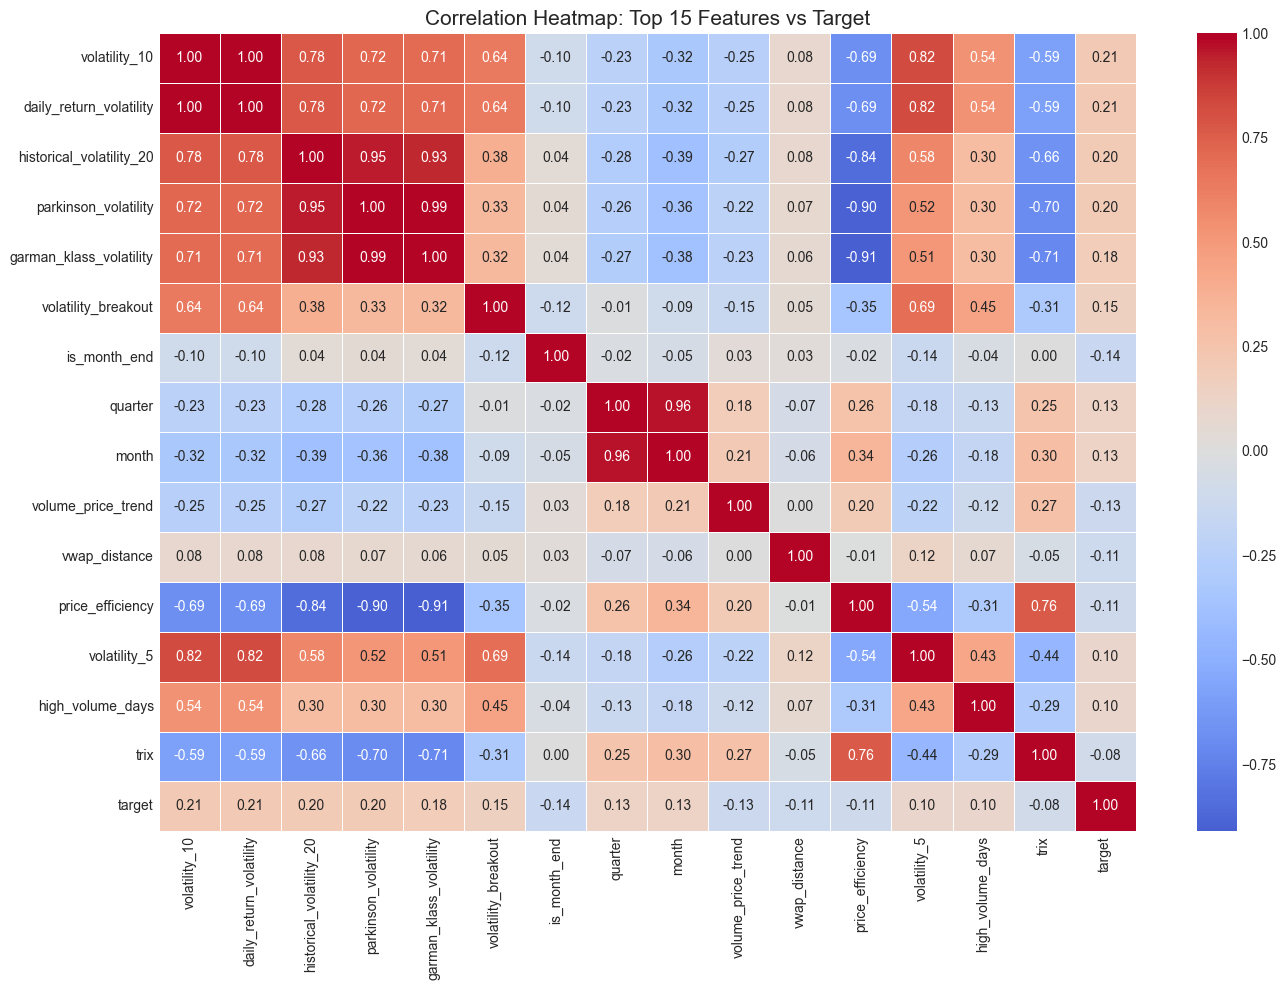

In [15]:

# Select top 15 features for visualization
top_15_features = correlations.abs().sort_values(ascending=False).head(15).index.tolist()
viz_data = train_features[top_15_features + ['target']]

# Compute correlation matrix
corr_matrix = viz_data.corr()

# Plot Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap: Top 15 Features vs Target', fontsize=15)
plt.tight_layout()
plt.show()



### 4. Model Training

We train the two component models on the selected features:
*   **LightGBM:** Optimized for directional accuracy.
*   **CatBoost:** Optimized for RMSE and stability.


In [16]:

# Prepare training matrices
X_train = train_features[top_features]
y_train = train_features['target']
X_test = test_features[top_features]
y_test = test_features['target']

# Train the ensemble (internally trains both sub-models)
model.train(X_train, y_train, X_test, y_test)



TRAINING ENSEMBLE MODEL

>>> Training LightGBM Component...

TRAINING LIGHTGBM MODEL
Training samples: 2814
Features: 41

✅ Training complete!
   Best iteration: 100

>>> Training CatBoost Component...

TRAINING CATBOOST MODEL
Training samples: 2814
Features: 41
0:	learn: 0.0399777	test: 0.0465155	best: 0.0465155 (0)	total: 3.28ms	remaining: 3.28s
100:	learn: 0.0278594	test: 0.0326372	best: 0.0326372 (100)	total: 232ms	remaining: 2.07s
200:	learn: 0.0242746	test: 0.0300805	best: 0.0300805 (200)	total: 448ms	remaining: 1.78s
300:	learn: 0.0216984	test: 0.0287653	best: 0.0287653 (300)	total: 631ms	remaining: 1.46s
400:	learn: 0.0195608	test: 0.0282701	best: 0.0282701 (400)	total: 819ms	remaining: 1.22s
500:	learn: 0.0177072	test: 0.0279253	best: 0.0278937 (474)	total: 999ms	remaining: 995ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.02784783329
bestIteration = 539

Shrink model to first 540 iterations.

✅ Training complete!
   Best iteration: 539

✅ Ensemble Tra


### 5. Evaluation & Trading Logic

The ensemble combines predictions using the pre-defined weights. We then apply a **2% Threshold** to generate actionable signals:
*   **BUY:** Predicted Return > +2%
*   **SELL:** Predicted Return < -2%
*   **HOLD:** Between -2% and +2% (Noise filter)



ENSEMBLE MODEL EVALUATION
Weights: LightGBM=0.4, CatBoost=0.6
------------------------------
RMSE:                     0.0275
MAE:                      0.0216 (2.16%)
R² Score:                 0.6575
Directional Accuracy:     76.12%
Trading Action Accuracy:  60.20%
  (Threshold: ±2.0%)

Trading Signal Confusion Matrix:
                 Predicted
Actual      SELL  HOLD   BUY
  SELL        24    24     1
  HOLD         5    50     8
  BUY          0    42    47


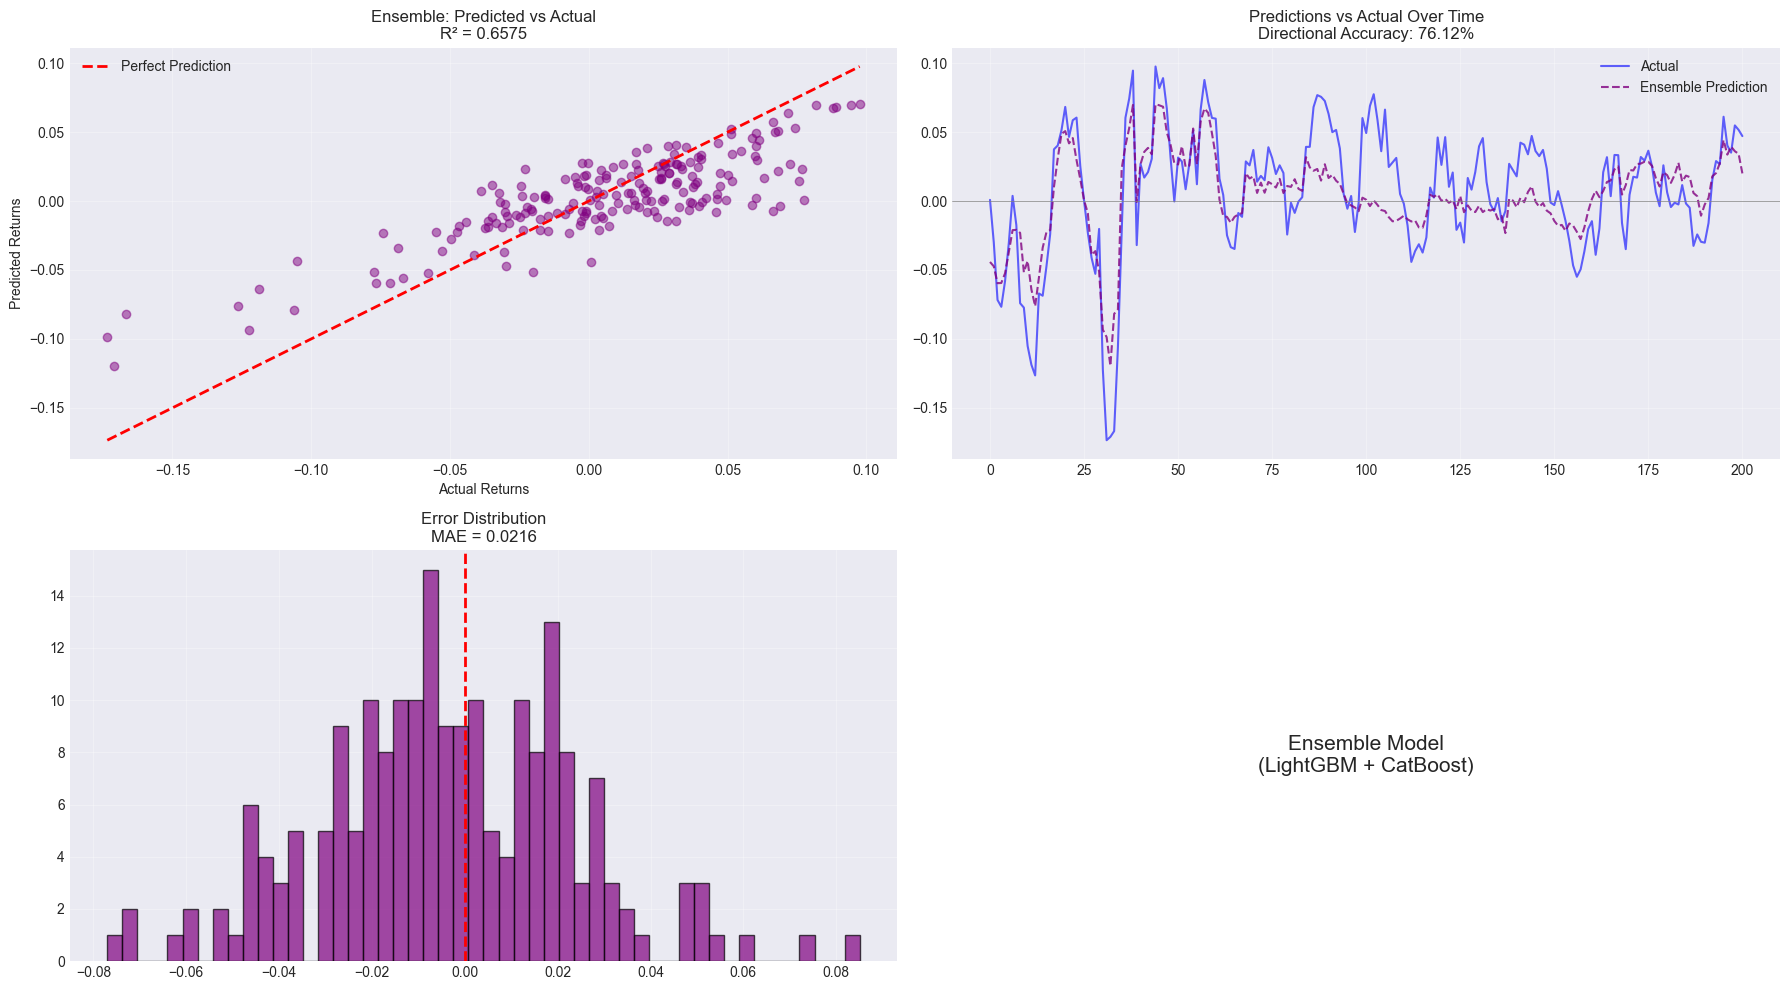

In [17]:

# Run evaluation on the Test Set (Citigroup)
results = model.evaluate(X_test, y_test)
model.print_evaluation(results)

# Plot performance metrics
model.plot_results(results)



### 6. Feature Importance Analysis

Understanding *why* the model makes decisions is crucial. We visualize the top features driving the predictions.


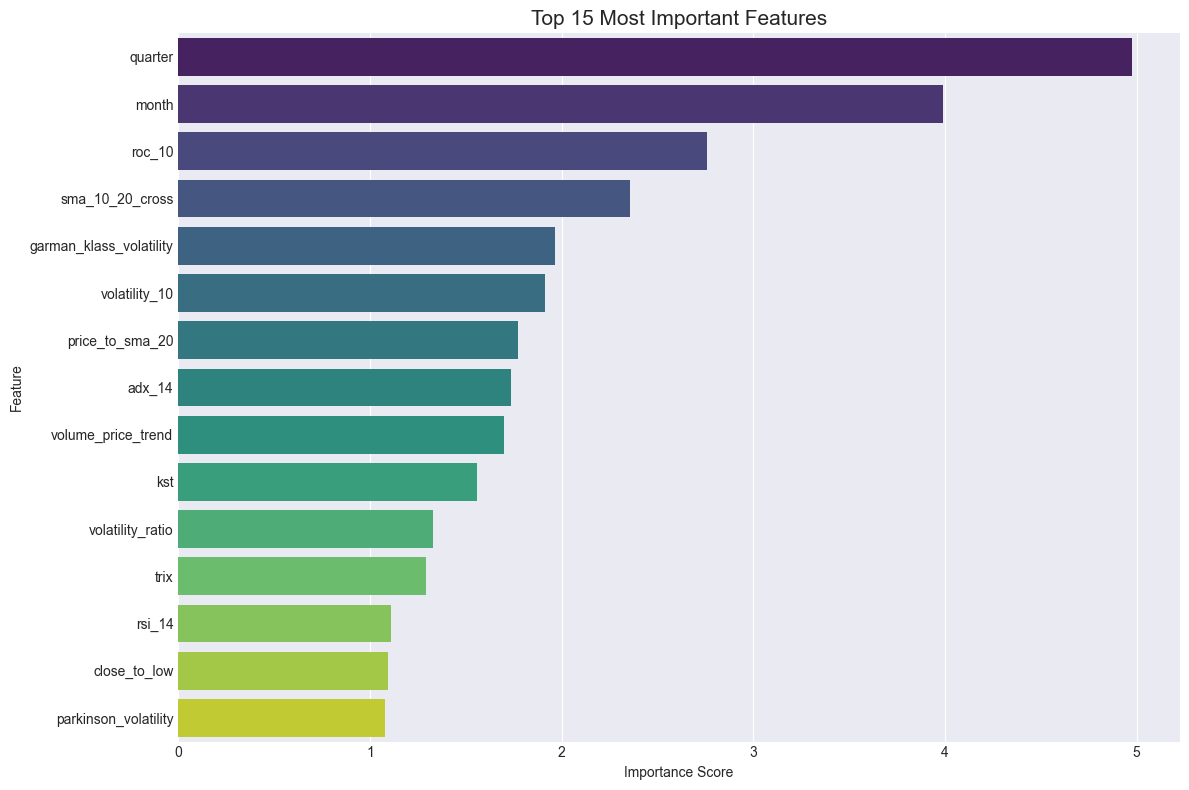

In [18]:

# Extract feature importance from the LightGBM component (as a proxy for the ensemble)
importance_df = results['feature_importance']

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 Most Important Features', fontsize=15)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



### 7. Comparative Analysis

We compare the performance of the individual models against the Ensemble to justify our approach.


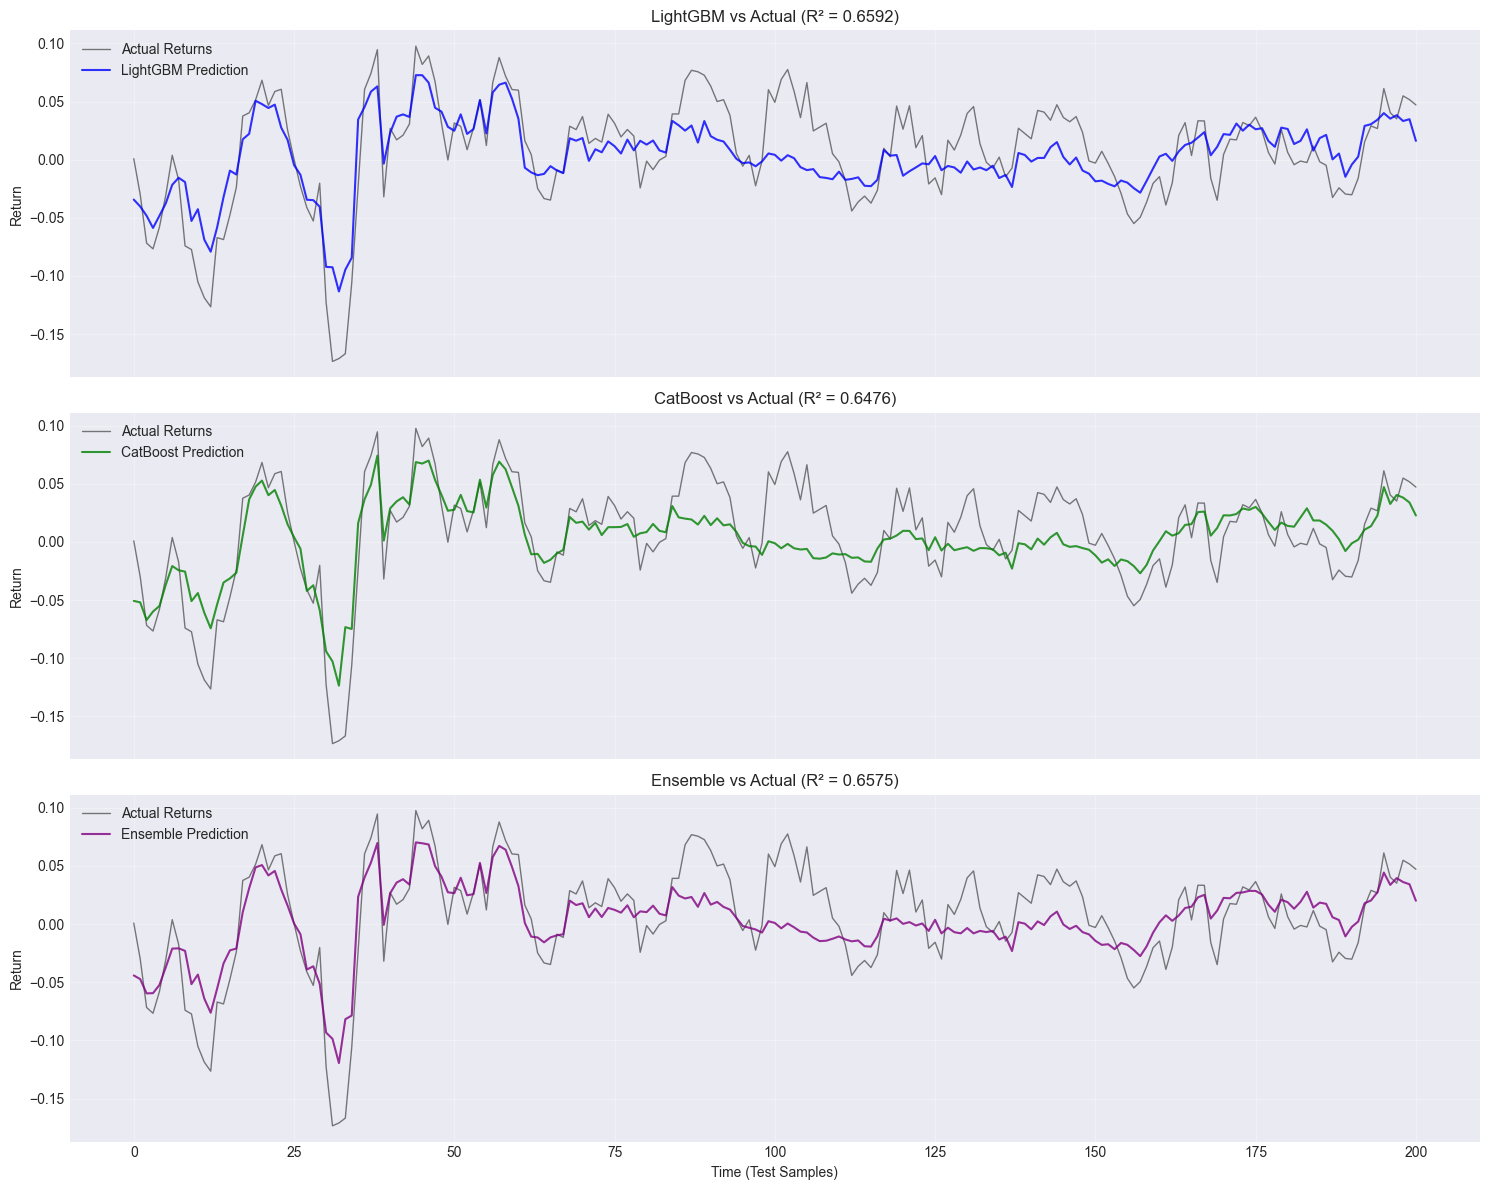

,Model,R2 Score,Directional Accuracy
0,LightGBM,0.659189,0.756219
1,CatBoost,0.647624,0.741294
2,Ensemble,0.657464,0.761194


In [19]:

from sklearn.metrics import r2_score

# 1. Get predictions from individual components
lgb_pred = model.lgb_model.predict(X_test)
cat_pred = model.cat_model.predict(X_test)

# 2. Calculate Metrics
metrics_data = {
    'Model': ['LightGBM', 'CatBoost', 'Ensemble'],
    'R2 Score': [
        r2_score(y_test, lgb_pred),
        r2_score(y_test, cat_pred),
        results['r2']
    ],
    'Directional Accuracy': [
        np.mean(np.sign(lgb_pred) == np.sign(y_test)),
        np.mean(np.sign(cat_pred) == np.sign(y_test)),
        results['directional_accuracy']
    ]
}

comp_df = pd.DataFrame(metrics_data)

# 3. Plot Comparison (Line Graphs)
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Common settings
y_actual = y_test.values
x_axis = range(len(y_actual))

# Plot 1: LightGBM
axes[0].plot(x_axis, y_actual, label='Actual Returns', color='black', alpha=0.5, linewidth=1)
axes[0].plot(x_axis, lgb_pred, label='LightGBM Prediction', color='blue', alpha=0.8, linewidth=1.5)
axes[0].set_title(f'LightGBM vs Actual (R² = {r2_score(y_test, lgb_pred):.4f})', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylabel('Return')

# Plot 2: CatBoost
axes[1].plot(x_axis, y_actual, label='Actual Returns', color='black', alpha=0.5, linewidth=1)
axes[1].plot(x_axis, cat_pred, label='CatBoost Prediction', color='green', alpha=0.8, linewidth=1.5)
axes[1].set_title(f'CatBoost vs Actual (R² = {r2_score(y_test, cat_pred):.4f})', fontsize=12)
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylabel('Return')

# Plot 3: Ensemble
axes[2].plot(x_axis, y_actual, label='Actual Returns', color='black', alpha=0.5, linewidth=1)
axes[2].plot(x_axis, results['predictions'], label='Ensemble Prediction', color='purple', alpha=0.8, linewidth=1.5)
axes[2].set_title(f'Ensemble vs Actual (R² = {results["r2"]:.4f})', fontsize=12)
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylabel('Return')
axes[2].set_xlabel('Time (Test Samples)')

plt.tight_layout()
plt.show()

# Display the raw numbers
comp_df



### 8. Model Persistence

Save the trained model for deployment.

In [20]:

# import joblib
# from datetime import datetime

# timestamp = datetime.now().strftime("%Y%m%d")
# filename = f'ensemble_model_v1_{timestamp}.pkl'

# # joblib.dump(model, filename)
# # print(f"Model saved to {filename}")
